In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import random
import gc
import h5py

In [2]:
from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2018/12/17 16:41:42


In [3]:
def initialize_c_corner_deleted(num_grid_, num_side_, scale_factor_):
    c = np.zeros((num_grid_+2, num_grid_+2, num_side_), dtype = np.float64)
        
    # setting side value
    for i in range(num_grid_-2):
        c[0+1, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of upper side
        c[0+1, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of upper side
        c[0+1, 0+1+1+i, 2] = 0.25/scale_factor_ # down side of upper side
    for i in range(num_grid_-2):
        c[num_grid_, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of bottom side
        c[num_grid_, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of bottom side
        c[num_grid_, 0+1+1+i, 0] = 0.25/scale_factor_ # upper side of bottom side
    for i in range(num_grid_-2):
        c[0+1+1+i, num_grid_, 0] = 0.375/scale_factor_ # upper side of right side
        c[0+1+1+i, num_grid_, 2] = 0.375/scale_factor_ # bottom side of right side
        c[0+1+1+i, num_grid_, 3] = 0.25/scale_factor_ # left side of right side
    for i in range(num_grid_-2):
        c[0+1+1+i, 0+1, 0] = 0.375/scale_factor_ # upper side of left side
        c[0+1+1+i, 0+1, 2] = 0.375/scale_factor_ # bottom side of left side
        c[0+1+1+i, 0+1, 1] = 0.25/scale_factor_ # right side of left side
    
    # connecting corner
    c[1, 1, 1] = c[1, 1, 2] = 0.375/scale_factor_ # upper left
    c[1, num_grid_, 2] = c[1, num_grid_, 3] = 0.375/scale_factor_ # upper right
    c[num_grid_, 1, 0] = c[num_grid_, 1, 1] = 0.375/scale_factor_ # bottom left
    c[num_grid_, num_grid_, 0] = c[num_grid_, num_grid_, 3] = 0.375/scale_factor_ # bottom right
    
    # setting most of the grid
    for i in range(num_grid_-2):
        for j in range(num_grid_-2):
            for k in range(4):
                c[i+2, j+2, k] = 0.25/scale_factor_
    
    #print(c)
    return c
    
c = initialize_c_corner_deleted(9, 4, 100)

In [4]:
class RK_MEA_grid:
    def __init__(self, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt, num_grid):
        self.J = J
        self.alpha = alpha
        self.tau = tau
        self.E_0_default = E_0_default
        self.t_fac = t_fac
        self.t_d = t_d
        self.t_th = t_th
        self.thre_effi = thre_effi
        self.U = U
        self.dt = dt
        self.num_grid = num_grid
        self.time = np.zeros(int(memory_reset_timing*(1/dt)), dtype = np.float64)
        self.E_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.u_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.x_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.z_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)

        
    def gain_function_(self, z):
        return self.alpha * math.log(1 + math.exp(z/self.alpha))

    def f_E(self, E_t, x_t, u_t, z_t, E_ext_input):
        return (-E_t + self.gain_function_(self.J * u_t * x_t * E_t + self.E_0_default + E_ext_input - self.thre_effi * z_t))/self.tau

    def f_x(self, E_t, x_t, u_t, z_t):
        return ((1 - x_t)/self.t_d - u_t * x_t * E_t)

    def f_u(self, E_t, x_t, u_t, z_t):
        return ((self.U - u_t)/self.t_fac + self.U * (1 - u_t) * E_t)

    def f_z(self, E_t, x_t, u_t, z_t):
        return (E_t - z_t)/self.t_th

    def compute_ext_E(self, c, grid_index_i, grid_index_j, E_offset, x_offset, u_offset, time_index_in_reset):
        return (c[grid_index_i+1-1, grid_index_j+1, 2] * (self.E_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1-1, grid_index_j+1]+x_offset)\
                +c[grid_index_i+1, grid_index_j+1+1, 3] * (self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1+1]+x_offset)\
                +c[grid_index_i+1+1, grid_index_j+1, 0] * (self.E_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+u_offset) * (self.x_t[time_index_in_reset, grid_index_i+1+1, grid_index_j+1]+x_offset)\
                +c[grid_index_i+1, grid_index_j+1-1, 1] * (self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+E_offset) * (self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+u_offset) *(self. x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1-1]+x_offset))

    def RK4(self, E_t, x_t, u_t, z_t, dt, grid_index_i, grid_index_j, time_index_in_reset):
        # compute k1
        k1_E = self.f_E(E_t, x_t, u_t, z_t, self.compute_ext_E(c, grid_index_i, grid_index_j, 0, 0, 0, time_index_in_reset))
        k1_x = self.f_x(E_t, x_t, u_t, z_t)
        k1_u = self.f_u(E_t, x_t, u_t, z_t)
        k1_z = self.f_z(E_t, x_t, u_t, z_t)
        # compute k2
        k2_E = self.f_E(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2, self.compute_ext_E(c, grid_index_i, grid_index_j, k1_E*dt/2, k1_x*dt/2, k1_u*dt/2, time_index_in_reset))
        k2_x = self.f_x(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_u = self.f_u(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        k2_z = self.f_z(E_t+k1_E*dt/2, x_t+k1_x*dt/2, u_t+k1_u*dt/2, z_t+k1_z*dt/2)
        # compute k3
        k3_E = self.f_E(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2, self.compute_ext_E(c, grid_index_i, grid_index_j, k2_E*dt/2, k2_x*dt/2, k2_u*dt/2, time_index_in_reset))
        k3_x = self.f_x(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_u = self.f_u(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        k3_z = self.f_z(E_t+k2_E*dt/2, x_t+k2_x*dt/2, u_t+k2_u*dt/2, z_t+k2_z*dt/2)
        # compute k4
        k4_E = self.f_E(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt, self.compute_ext_E(c, grid_index_i, grid_index_j, k3_E*dt, k3_x*dt, k3_u*dt, time_index_in_reset))
        k4_x = self.f_x(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_u = self.f_u(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        k4_z = self.f_z(E_t+k3_E*dt, x_t+k3_x*dt, u_t+k3_u*dt, z_t+k3_z*dt)
        # compute y_n+1
        return (E_t+(k1_E+2.*k2_E+2.*k3_E+k4_E)*dt/6.), (x_t+(k1_x+2.*k2_x+2.*k3_x+k4_x)*dt/6.), (u_t+(k1_u+2.*k2_u+2.*k3_u+k4_u)*dt/6.), (z_t+(k1_z+2.*k2_z+2.*k3_z+k4_z)*dt/6.)

    def init_dynamical_variable_and_time_with_memory_reset(self, num_grid, T, E_ini, u_ini, x_ini, z_ini, memory_reset_timing):
        self.E_t[0, :, :] = E_ini
        if E_ini != 0:
            self.E_t[:, 0, :] = self.E_t[:, num_grid + 1, :] = self.E_t[:, :, 0] = self.E_t[:, :, num_grid + 1] = 0
        self.u_t[0, :, :] = u_ini
        if u_ini != 0:
            self.u_t[:, 0, :] = self.u_t[:, num_grid + 1, :] = self.u_t[:, :, 0] = self.u_t[:, :, num_grid + 1] = 0
        self.x_t[0, :, :] = x_ini
        if x_ini != 0:
            self.x_t[:, 0, :] = self.x_t[:, num_grid + 1, :] = self.x_t[:, :, 0] = self.x_t[:, :, num_grid + 1] = 0
        self.z_t[0, :, :] = z_ini
    
    def start_simulation_with_gc(self, T, memory_reset_timing, data_dir_name='no'):
        print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(self.num_grid, self.num_grid, int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        print(self.E_t[0,:,:])
        for i in range(int(T) - 1):
            time_index_in_reset = i%int(memory_reset_timing*(1/self.dt))
            if (time_index_in_reset+1 == int(memory_reset_timing*(1/self.dt))):
                if (int((i+1)%10000000)==0):
                    self.data_dump_and_reset(True, '{}/{}_{}.h5'.format(data_dir_name, int((i+1)*self.dt) - memory_reset_timing, int((i+1)*self.dt)))
                else:
                    self.data_dump_and_reset()
            else:
                self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
                #self.time[time_index_in_reset+1] = (i+1) * self.dt
                if time_index_in_reset == 0:
                    print("resetted i {}".format(int(i*self.dt)))
                for grid_index_i in range(self.num_grid):
                    for grid_index_j in range(self.num_grid):
                        self.E_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], self.x_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], self.u_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1]\
                        , self.z_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1] = self.RK4(E_t=self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], x_t=self.x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], u_t=self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], z_t=self.z_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], dt=self.dt, grid_index_i = grid_index_i, grid_index_j=grid_index_j, time_index_in_reset=time_index_in_reset)
                # setting corner value
                self.E_t[time_index_in_reset+1, 1, 1], self.x_t[time_index_in_reset+1, 1, 1], self.u_t[time_index_in_reset+1, 1, 1] = (self.E_t[time_index_in_reset+1, 1, 2] + self.E_t[time_index_in_reset+1, 2, 1])/2, (self.x_t[time_index_in_reset+1, 1, 2] + self.x_t[time_index_in_reset+1, 2, 1])/2, (self.u_t[time_index_in_reset+1, 1, 2] + self.u_t[time_index_in_reset+1, 2, 1])/2 # upper left 
                #print("E_t[{}, 1, 1] = ({} + {})/2 = {}".format(i+1, E_t[i+1, 1, 2], E_t[i+1, 2, 1], E_t[i+1, 1, 1]))
                self.E_t[time_index_in_reset+1, 1, num_grid], self.x_t[time_index_in_reset+1, 1, num_grid], self.u_t[time_index_in_reset+1, 1, num_grid] = (self.E_t[time_index_in_reset+1, 2, num_grid]+self.E_t[time_index_in_reset+1, 1, num_grid-1])/2, (self.x_t[time_index_in_reset+1, 2, num_grid]+self.x_t[time_index_in_reset+1, 1, num_grid-1])/2, (self.u_t[time_index_in_reset+1, 2, num_grid]+self.u_t[time_index_in_reset+1, 1, num_grid-1])/2 # upper right
                self.E_t[time_index_in_reset+1, num_grid, 1], self.x_t[time_index_in_reset+1, num_grid, 1], self.u_t[time_index_in_reset+1, num_grid, 1] = (self.E_t[time_index_in_reset+1, num_grid, 2]+self.E_t[time_index_in_reset+1, num_grid-1, 1])/2, (self.x_t[time_index_in_reset+1, num_grid, 2]+self.x_t[time_index_in_reset+1, num_grid-1, 1])/2, (self.u_t[time_index_in_reset+1, num_grid, 2]+self.u_t[time_index_in_reset+1, num_grid-1, 1])/2 # bottom left
                self.E_t[time_index_in_reset+1, num_grid, num_grid], self.x_t[time_index_in_reset+1, num_grid, num_grid], self.u_t[time_index_in_reset+1, num_grid, num_grid] = (self.E_t[time_index_in_reset+1, num_grid-1, num_grid]+self.E_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (self.x_t[time_index_in_reset+1, num_grid-1, num_grid]+self.x_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (self.u_t[time_index_in_reset+1, num_grid-1, num_grid]+self.u_t[time_index_in_reset+1, num_grid, num_grid-1])/2 # bottom right
                #print("{} th iteration finished".format(time_index_in_reset))
                if int(i%100000) == 0:
                    print("~{} sec finished. {}".format(int(i*self.dt), datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        with h5py.File('{}/{}_{}.h5'.format(data_dir_name, 'final', int((i+2)*self.dt))) as f:
            f.create_group('sim_data')
            f.create_dataset('sim_data/E_t', data = rk_mea_grid.E_t)
            f.create_dataset('sim_data/x_t', data = rk_mea_grid.x_t)
            f.create_dataset('sim_data/u_t', data = rk_mea_grid.u_t)
            f.create_dataset('sim_data/z_t', data = rk_mea_grid.z_t)
            print("time series data dumped.")
        print("simulation completed !")

    def data_dump_and_reset(self, dump = False, dump_name='no'):
        if dump:
            with h5py.File(dump_name) as f:
                f.create_group('sim_data')
                f.create_dataset('sim_data/E_t', data = self.E_t)
                f.create_dataset('sim_data/x_t', data = self.x_t)
                f.create_dataset('sim_data/u_t', data = self.u_t)
                f.create_dataset('sim_data/z_t', data = self.z_t)
            print("data dumped.")
        tmp_E_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
        tmp_x_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
        tmp_u_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)
        tmp_z_t = np.zeros((1, num_grid + 2, num_grid + 2), dtype = np.float64)

        tmp_E_t = self.E_t[int(memory_reset_timing*(1/dt))-1,:,:]
        tmp_x_t = self.x_t[int(memory_reset_timing*(1/dt))-1,:,:]
        tmp_u_t = self.u_t[int(memory_reset_timing*(1/dt))-1,:,:]
        tmp_z_t = self.z_t[int(memory_reset_timing*(1/dt))-1,:,:]
        print("tmp Et {}".format(tmp_E_t))
        del self.E_t
        del self.x_t
        del self.u_t
        del self.z_t
        gc.collect()
        self.E_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.x_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.u_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.z_t = np.zeros((int(memory_reset_timing*(1/dt)), num_grid + 2, num_grid + 2), dtype = np.float64)
        self.E_t[0,:,:] = tmp_E_t
        self.x_t[0,:,:] = tmp_x_t
        self.u_t[0,:,:] = tmp_u_t
        self.z_t[0,:,:] = tmp_z_t
        print("resetted memory and load last value as init value")

    def start_simulation_with_gc_from_data(self, load_name, save_name, start_time, T, memory_reset_timing):
        print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(self.num_grid, self.num_grid, int(T*self.dt)))
        print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(self.tau, self.t_fac, self.t_d, self.t_th, self.U))
        print("J {} alpha {} thre_effi {}".format(self.J, self.alpha, self.thre_effi))
        with h5py.File(load_name) as f:
            self.E_t = np.array(f['sim_data/E_t'])
            self.u_t = np.array(f['sim_data/u_t'])
            self.x_t = np.array(f['sim_data/x_t'])
            self.z_t = np.array(f['sim_data/z_t'])
        self.data_dump_and_reset()
        print("data loaded {}".format(self.E_t[0,:,:]))
        for i in range(int(T) - 1):
            time_index_in_reset = i%int(memory_reset_timing*(1/self.dt))
            if (time_index_in_reset+1 == int(memory_reset_timing*(1/self.dt))):
                if (int((i+1)%10000000)==0):
                    self.data_dump_and_reset(True, 'data/{}_{}_from_{}.h5'.format(int((i+start_time*(1/self.dt)+1)*self.dt) - memory_reset_timing, int((i+start_time*(1/self.dt)+1)*self.dt), save_name))
                else:
                    self.data_dump_and_reset()
            else:
                self.time[time_index_in_reset+1] = (time_index_in_reset+1) * self.dt
                #self.time[time_index_in_reset+1] = (i+1) * self.dt
                if time_index_in_reset == 0:
                    print("resetted i {}".format(int((i+start_time*(1/self.dt))*self.dt)))
                for grid_index_i in range(self.num_grid):
                    for grid_index_j in range(self.num_grid):
                        self.E_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], self.x_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1], self.u_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1]\
                        , self.z_t[time_index_in_reset+1, grid_index_i+1, grid_index_j+1] = self.RK4(E_t=self.E_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], x_t=self.x_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], u_t=self.u_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], z_t=self.z_t[time_index_in_reset, grid_index_i+1, grid_index_j+1], dt=self.dt, grid_index_i = grid_index_i, grid_index_j=grid_index_j, time_index_in_reset=time_index_in_reset)
                # setting corner value
                self.E_t[time_index_in_reset+1, 1, 1], self.x_t[time_index_in_reset+1, 1, 1], self.u_t[time_index_in_reset+1, 1, 1] = (self.E_t[time_index_in_reset+1, 1, 2] + self.E_t[time_index_in_reset+1, 2, 1])/2, (self.x_t[time_index_in_reset+1, 1, 2] + self.x_t[time_index_in_reset+1, 2, 1])/2, (self.u_t[time_index_in_reset+1, 1, 2] + self.u_t[time_index_in_reset+1, 2, 1])/2 # upper left 
                #print("E_t[{}, 1, 1] = ({} + {})/2 = {}".format(i+1, E_t[i+1, 1, 2], E_t[i+1, 2, 1], E_t[i+1, 1, 1]))
                self.E_t[time_index_in_reset+1, 1, num_grid], self.x_t[time_index_in_reset+1, 1, num_grid], self.u_t[time_index_in_reset+1, 1, num_grid] = (self.E_t[time_index_in_reset+1, 2, num_grid]+self.E_t[time_index_in_reset+1, 1, num_grid-1])/2, (self.x_t[time_index_in_reset+1, 2, num_grid]+self.x_t[time_index_in_reset+1, 1, num_grid-1])/2, (self.u_t[time_index_in_reset+1, 2, num_grid]+self.u_t[time_index_in_reset+1, 1, num_grid-1])/2 # upper right
                self.E_t[time_index_in_reset+1, num_grid, 1], self.x_t[time_index_in_reset+1, num_grid, 1], self.u_t[time_index_in_reset+1, num_grid, 1] = (self.E_t[time_index_in_reset+1, num_grid, 2]+self.E_t[time_index_in_reset+1, num_grid-1, 1])/2, (self.x_t[time_index_in_reset+1, num_grid, 2]+self.x_t[time_index_in_reset+1, num_grid-1, 1])/2, (self.u_t[time_index_in_reset+1, num_grid, 2]+self.u_t[time_index_in_reset+1, num_grid-1, 1])/2 # bottom left
                self.E_t[time_index_in_reset+1, num_grid, num_grid], self.x_t[time_index_in_reset+1, num_grid, num_grid], self.u_t[time_index_in_reset+1, num_grid, num_grid] = (self.E_t[time_index_in_reset+1, num_grid-1, num_grid]+self.E_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (self.x_t[time_index_in_reset+1, num_grid-1, num_grid]+self.x_t[time_index_in_reset+1, num_grid, num_grid-1])/2, (self.u_t[time_index_in_reset+1, num_grid-1, num_grid]+self.u_t[time_index_in_reset+1, num_grid, num_grid-1])/2 # bottom right
                #print("{} th iteration finished".format(time_index_in_reset))
                if int(i%100000) == 0:
                    print("~{} sec finished. {}".format(int((i+start_time*(1/self.dt))*self.dt), datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
        with h5py.File('data/{}_{}.h5'.format('final', int((i+start_time*(1/self.dt)+2)*self.dt))) as f:
            f.create_group('sim_data')
            f.create_dataset('sim_data/E_t', data = rk_mea_grid.E_t)
            f.create_dataset('sim_data/x_t', data = rk_mea_grid.x_t)
            f.create_dataset('sim_data/u_t', data = rk_mea_grid.u_t)
            f.create_dataset('sim_data/z_t', data = rk_mea_grid.z_t)
            print("time series data dumped.")
        print("simulation completed !")

In [5]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [6]:
# param
T = 100 * (1/dt)
memory_reset_timing = 100
num_grid = 9
num_side = 4
scale_factor= 10
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
#E_0_default = -3
J = 8
alpha = 0.985

In [7]:
rk_mea_grid = RK_MEA_grid(J=J, alpha=alpha, tau=tau, E_0_default=E_0_default, t_fac=t_fac, t_d=t_d, t_th=t_th, thre_effi=thre_effi, U=U, dt=dt, num_grid = num_grid)

In [8]:
rk_mea_grid.init_dynamical_variable_and_time_with_memory_reset(num_grid=num_grid, T=T, E_ini=E_ini, u_ini=u_ini, x_ini=x_ini, z_ini=z_ini, memory_reset_timing=memory_reset_timing)

In [9]:
# initial condition for random init condition
for i in range(num_grid):
    for j in range(num_grid):
        rk_mea_grid.E_t[0, i+1, j+1] = random.randint(0, 10)
        #rk_mea_grid.u_t[0, i+1, j+1] = random.randint(0, 10)/10
        #rk_mea_grid.x_t[0, i+1, j+1] = random.randint(0, 10)/10

In [10]:
rk_mea_grid.start_simulation_with_gc(T, memory_reset_timing, data_dir_name='data_scale_factor_10')

starting sinulation
grid size 9*9 simulation time 100sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   3.  10.   2.   0.   6.   5.   3.   1.   9.   0.]
 [  0.   1.   7.   9.   1.   8.   0.  10.   6.   7.   0.]
 [  0.   9.  10.   1.   9.   1.  10.  10.   9.   8.   0.]
 [  0.   2.  10.   5.   9.   4.   7.   2.   9.   8.   0.]
 [  0.   4.   7.   3.   0.   3.  10.   2.   0.   1.   0.]
 [  0.   0.   8.   7.   5.   3.   6.   9.   0.   4.   0.]
 [  0.   9.   3.   9.   2.   8.   6.  10.   4.   3.   0.]
 [  0.   5.   4.   5.   4.   2.   8.   9.   6.   3.   0.]
 [  0.   3.   5.   8.   8.   1.   8.   2.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
resetted i 0
~0 sec finished. 2018/12/17 16:43:48
~10 sec finished. 2018/12/17 16:49:47
~20 sec finished. 2018/12/17 16:55:56
~30 sec finished. 2018/12/17 17:02:12
~40 sec finished. 2018/12/17 17:08:38
~50 sec

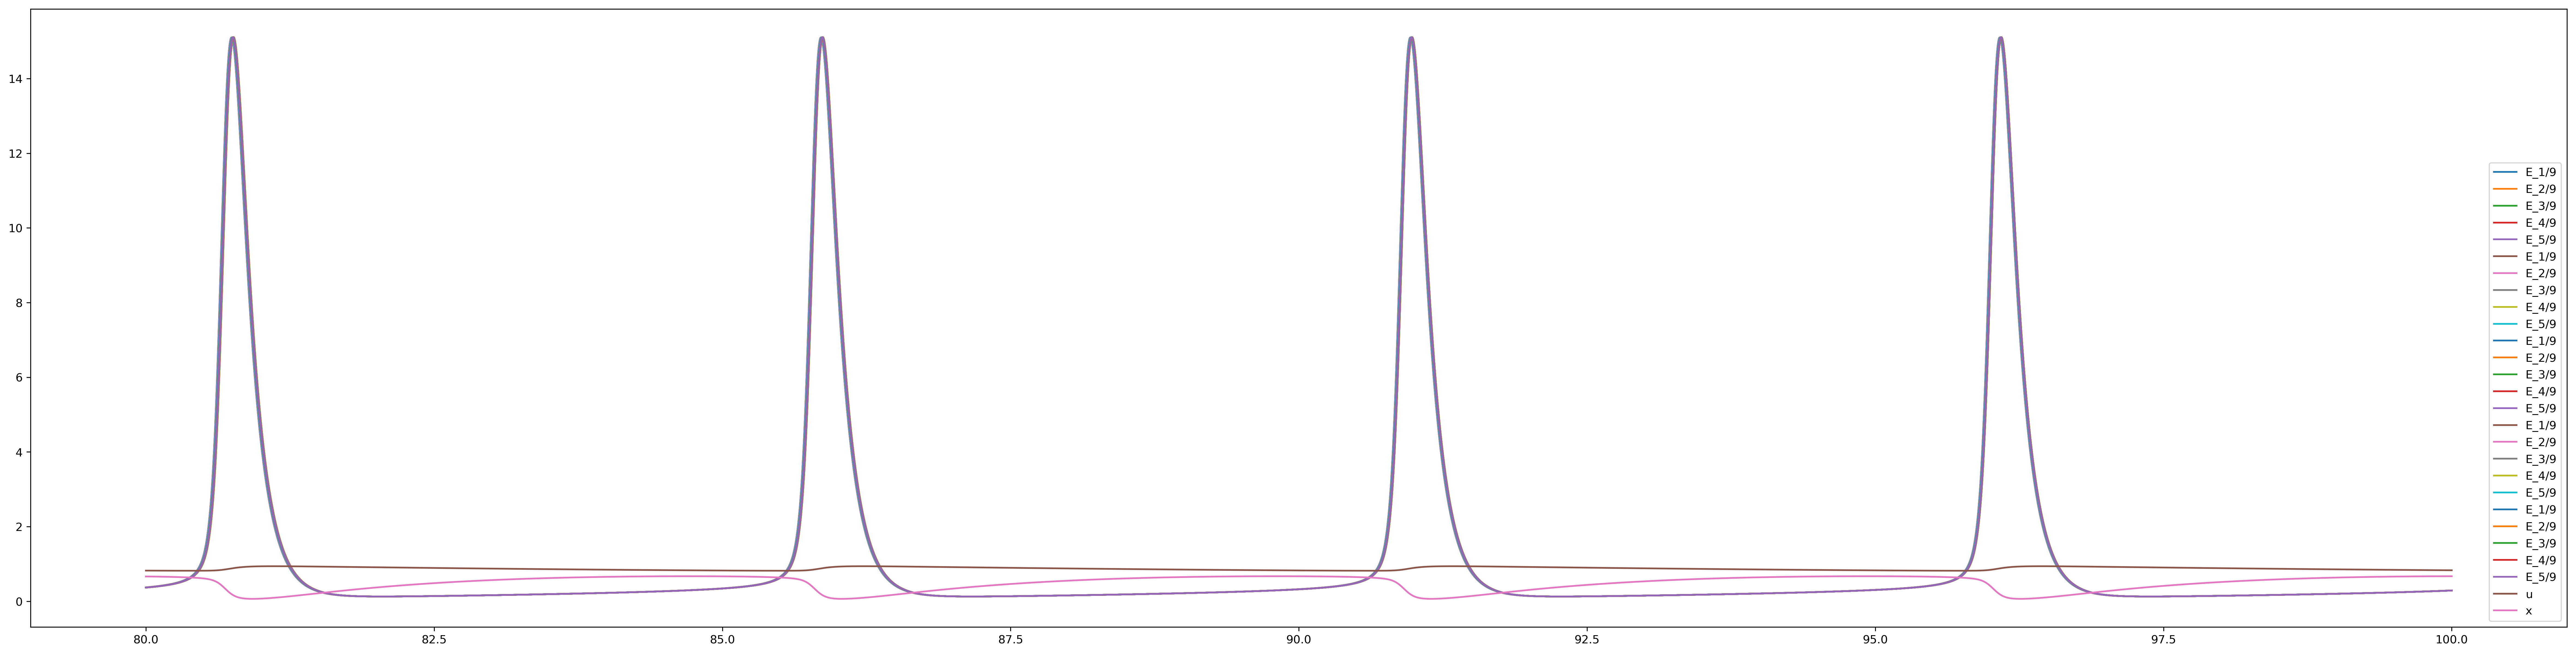

In [12]:
def plot_results_from_data(data_name, plot_dpi, start_time, end_time):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    with h5py.File(data_name) as f:
        loaded_E_t = np.array(f['sim_data/E_t'])
        loaded_x_t = np.array(f['sim_data/x_t'])
        loaded_u_t = np.array(f['sim_data/u_t'])
        for index_grid_i in range(int((num_grid+1)/2)):
            for index_grid_j in range(int((num_grid+1)/2)):
                plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_E_t[int(start_time*(1/dt)):int(end_time*(1/dt)),index_grid_i+1,index_grid_j+1], label="E_{}/{}".format(index_grid_j+1, num_grid))
        plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_u_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="u")
        plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], loaded_x_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="x")
        #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

"""
for i in range(int(memory_reset_timing*(1/dt))-1):
    rk_mea_grid.time[i+1] = (i+1) *rk_mea_grid.dt
"""


plot_results_from_data('data/final_100.h5', 300, 80, 100)

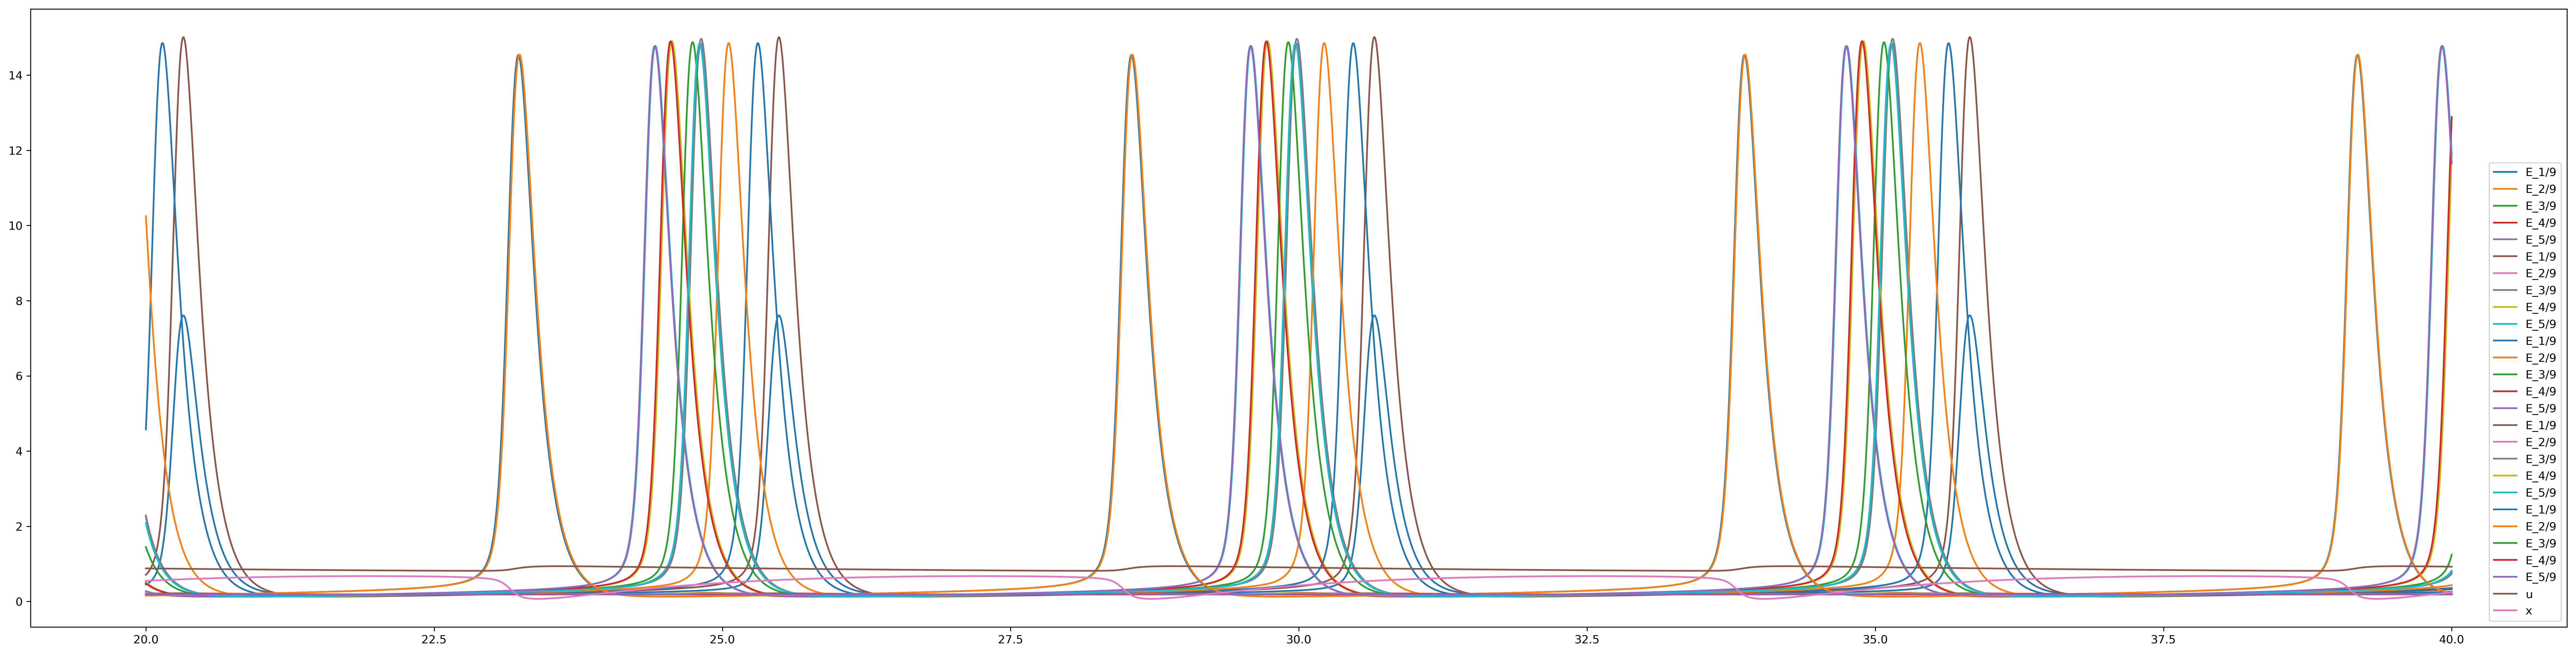

In [15]:
plot_results_from_data('data/11400_11500_from_3400_3500.h5', 300, 20, 40)

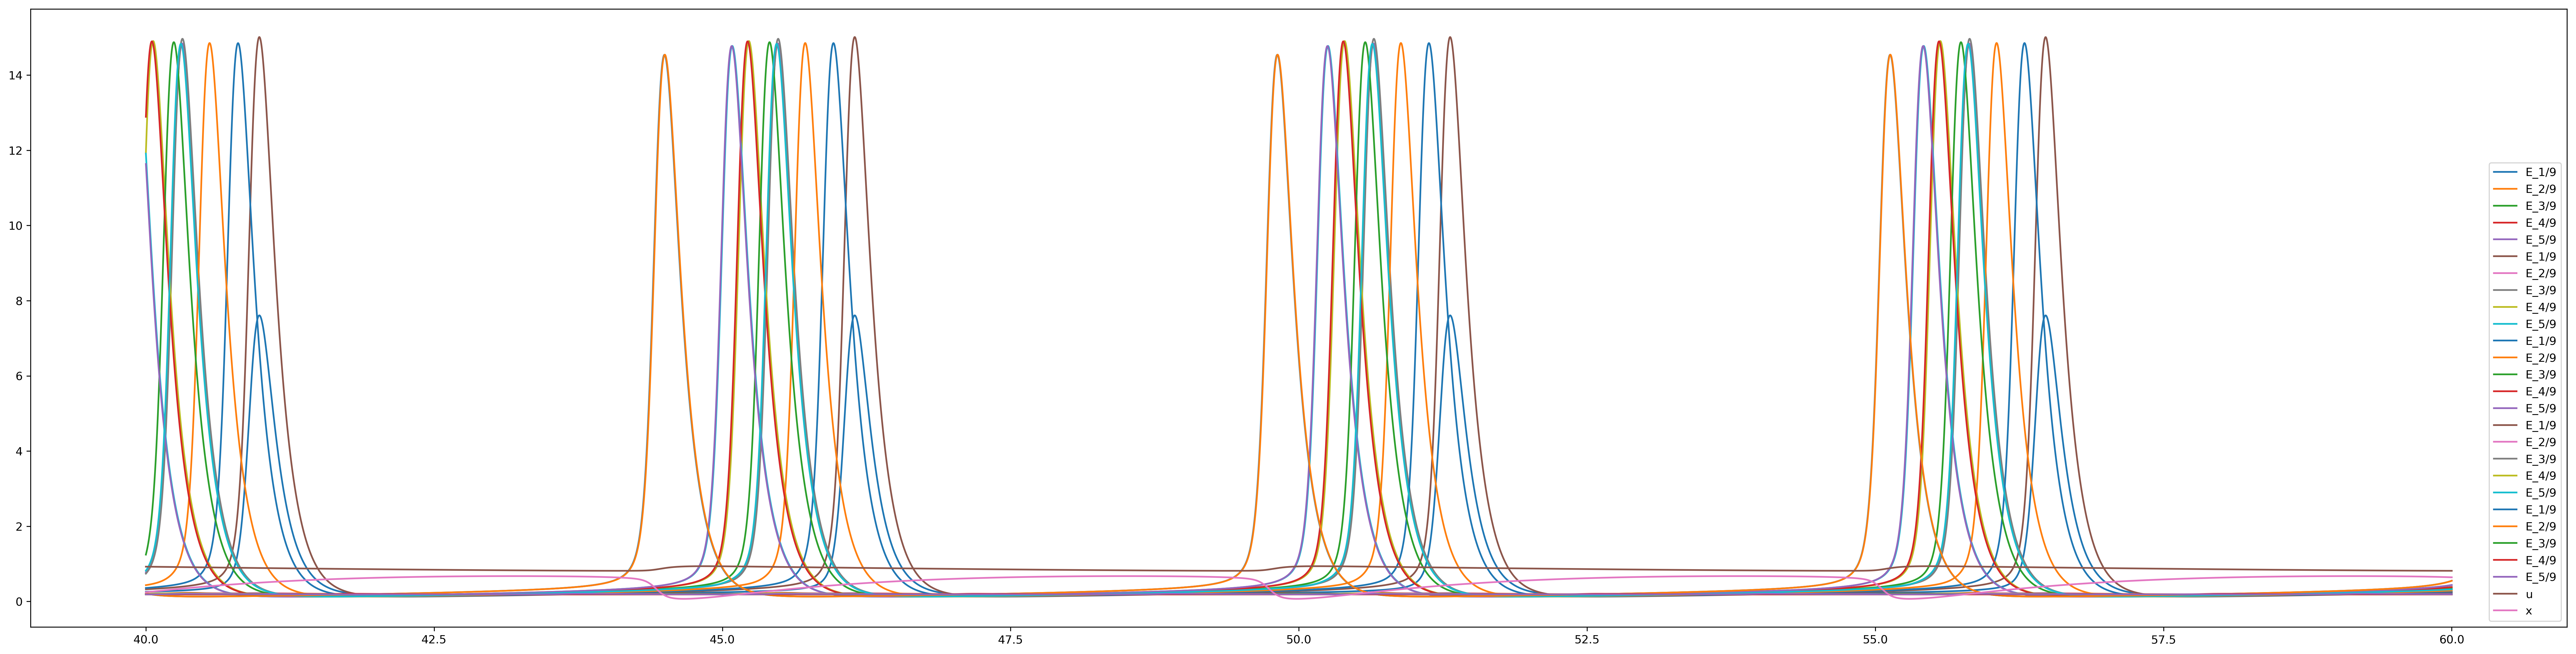

In [16]:
plot_results_from_data('data/11400_11500_from_3400_3500.h5', 300, 40, 60)

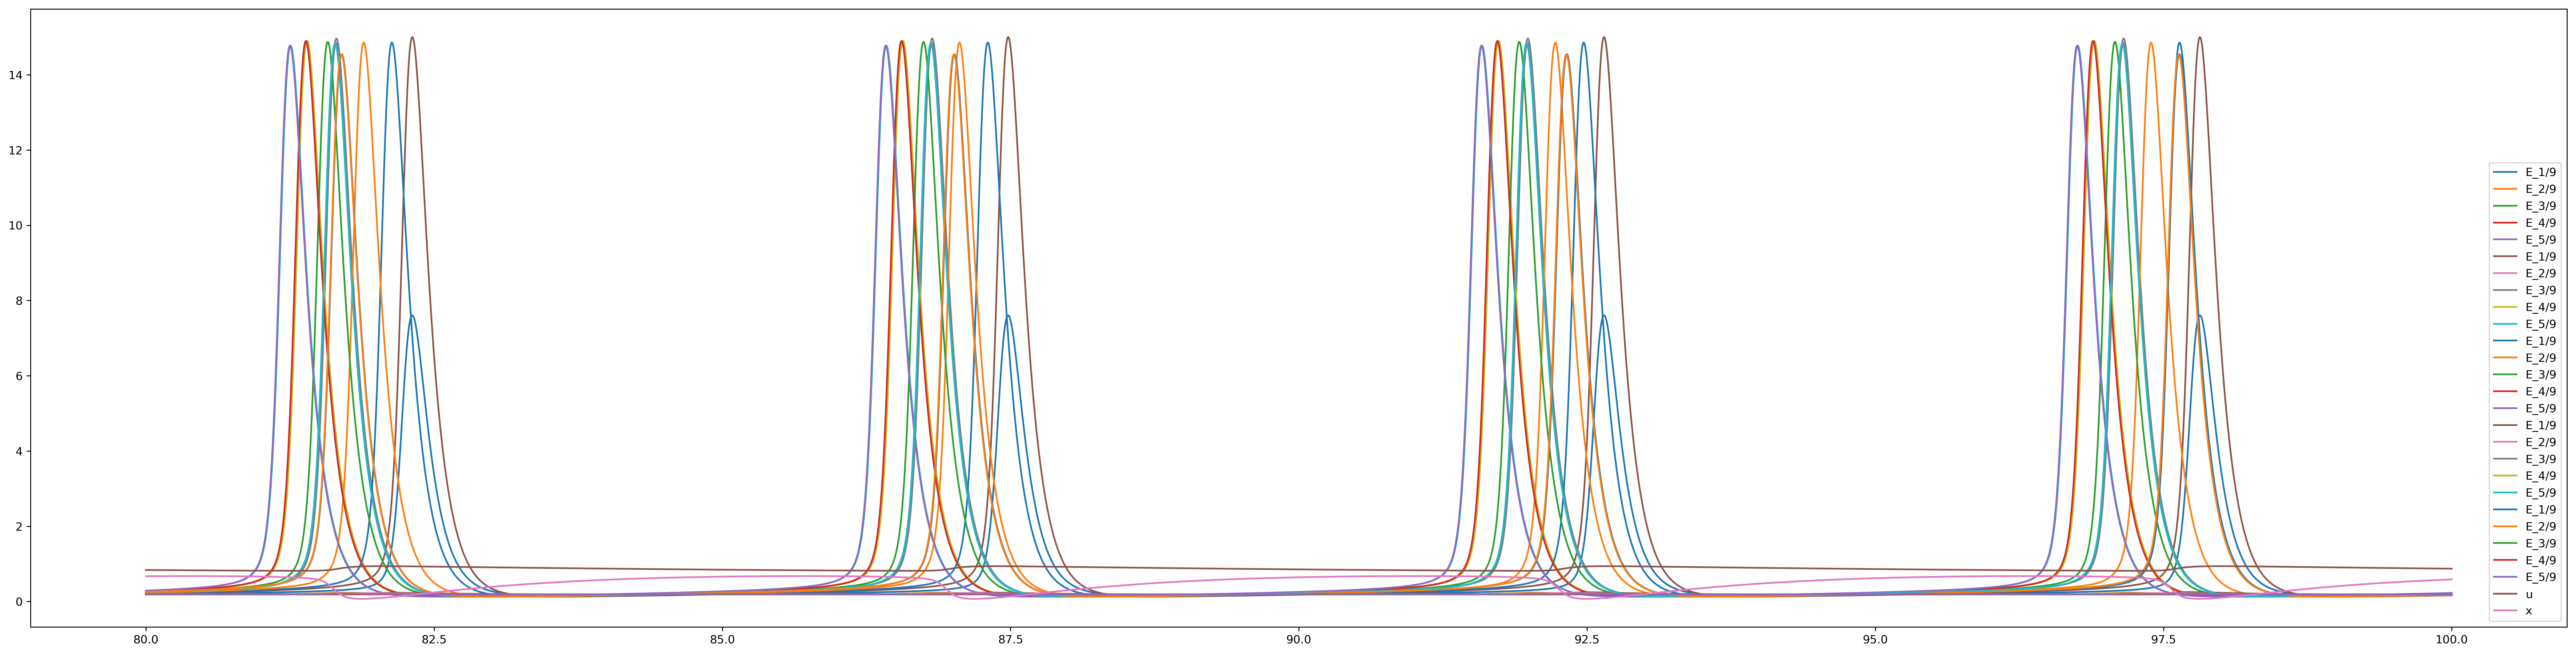

In [20]:
plot_results_from_data('data/11400_11500_from_3400_3500.h5', 300, 80, 100)

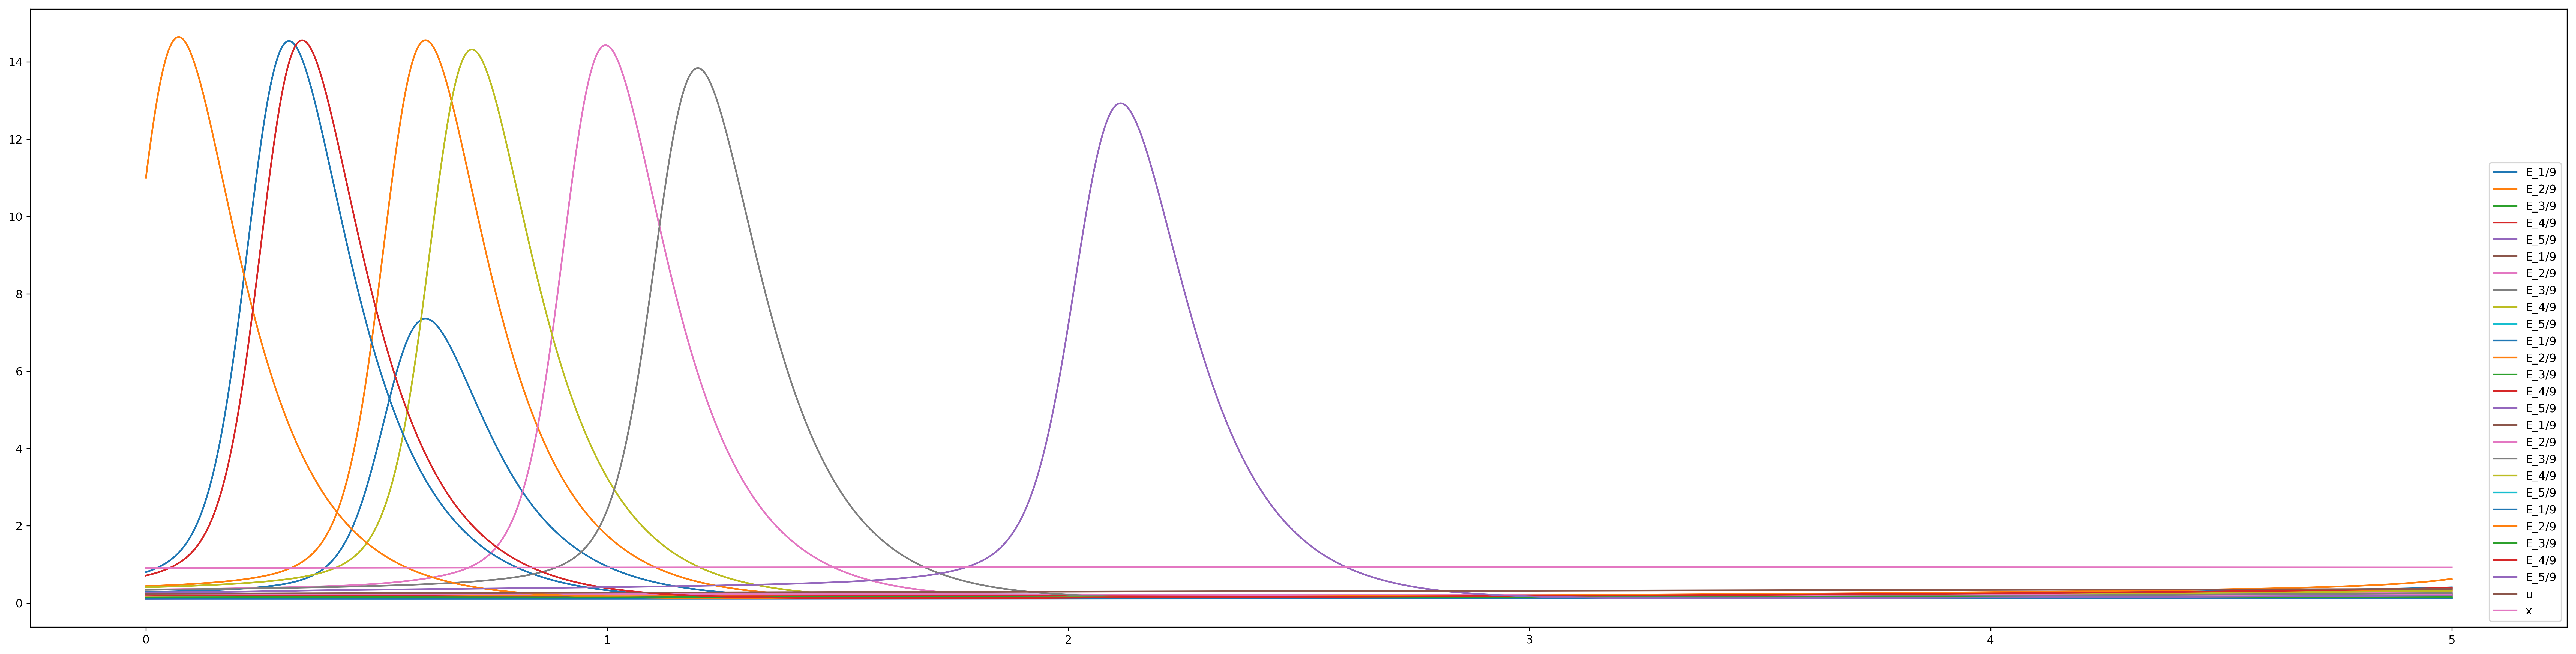

In [11]:
def plot_results(plot_dpi, start_time, end_time):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    #index_grid_i = int((num_grid+1)/2)
    for index_grid_i in range(int((num_grid+1)/2)):
        for index_grid_j in range(int((num_grid+1)/2)):
            plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_mea_grid.E_t[int(start_time*(1/dt)):int(end_time*(1/dt)),index_grid_i+1,index_grid_j+1], label="E_{}/{}".format(index_grid_j+1, num_grid))
    plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_mea_grid.u_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="u")
    plt.plot(rk_mea_grid.time[int(start_time*(1/dt)):int(end_time*(1/dt))], rk_mea_grid.x_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="x")
    #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

plot_results(300, 0, 100)

In [37]:
def plot_3d_color_surface_from_data(data_name, plot_length, start_time, outdir):
    with h5py.File(data_name) as f:
        loaded_E_t = np.array(f['sim_data/E_t'])
        loaded_x_t = np.array(f['sim_data/x_t'])
        loaded_u_t = np.array(f['sim_data/u_t'])
        plt.clf()

        ax = plt.gca(projection = '3d')
        ax.set_zlim(0, loaded_E_t.max())

        levels = MaxNLocator(nbins=30).tick_values(loaded_E_t.max(), loaded_E_t.min())

        cmap = plt.get_cmap('plasma')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)


        X_=np.arange(1, num_grid+1, 1)
        Y_=np.arange(1, num_grid+1, 1)
        X_, Y_ = np.meshgrid(X_, Y_)
    
        for t in range(int(plot_length*(1/dt)/10)):
            plt.clf()
            ax = plt.gca(projection = '3d')
            ax.set_zlim(0, loaded_E_t.max())

            surf = ax.plot_surface(X_, Y_, loaded_E_t[t*10 + int(start_time*(1/dt)) -1, 1:num_grid+1, 1:num_grid+1], cmap=cm.plasma, norm=norm)
            plt.colorbar(surf)
            plt.title("t = {} msec".format(t))
            fname = "/%s/%07d" % (outdir, t)
            plt.savefig('{}.png'.format(os.getcwd()+fname), dpi = 100)
            if (t % 1000) == 0:
                print("~{}/{} sec completed".format(int(t*dt*10), int(plot_length)))
            plt.close()
    print("finished !")

plot_3d_color_surface_from_data('data_scale_factor_5/8900_9000.h5', 10, 0, '3d_plot_8900_8910')

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


In [19]:
plot_3d_color_surface_from_data('data/11400_11500_from_3400_3500.h5', 10, 54, '3d_plot_11454_11464')

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


In [21]:
plot_3d_color_surface_from_data('data/11400_11500_from_3400_3500.h5', 10, 90, '3d_plot_11490_11500/')

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


In [13]:
np.savez_compressed('data/test.npz', array_1 = rk_mea_grid.E_t, array_2 = rk_mea_grid.u_t, array_3 = rk_mea_grid.x_t)
loaded_array = np.load('data/test.npz')
print(loaded_array['array_1'])

[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.28783686  0.4402192  ...,  0.21687108  0.28789449  0.        ]
  [ 0.          0.13545453  0.3504386  ...,  0.12041538  0.35891791  0.        ]
  ..., 
  [ 0.          0.12361377  0.13115878 ...,  0.30616797  2.4617687   0.        ]
  [ 0.          0.30338821  0.48316265 ...,  0.14767754  1.30472312  0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.28785993  0.44026428 ...,  0.21687243  0.28790298  0.        ]
  [ 0.          0.13545559  0.35045337 ...,  0.12041583  0.35893353  0.        ]
  ..., 
  [ 0.          0.12361429  0.13115966 ...,  0.30617955  2.465253    0.        ]
  [ 0.          0.30342141  0.48322853 ...,  0.14767956  1.30646628  0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.  

In [15]:
import h5py

In [17]:
with h5py.File('data/h5py_test_{}.h5'.format(0)) as f:
    f.create_group('sim_data')
    f.create_dataset('sim_data/E_t', data = rk_mea_grid.E_t)
with h5py.File('data/h5py_test_{}.h5'.format(0)) as f:
    loaded_E_t_h5 = np.array(f['sim_data/E_t'])
    print(loaded_E_t_h5)

[[[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.28783686  0.4402192  ...,  0.21687108  0.28789449  0.        ]
  [ 0.          0.13545453  0.3504386  ...,  0.12041538  0.35891791  0.        ]
  ..., 
  [ 0.          0.12361377  0.13115878 ...,  0.30616797  2.4617687   0.        ]
  [ 0.          0.30338821  0.48316265 ...,  0.14767754  1.30472312  0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.          0.          0.         ...,  0.          0.          0.        ]
  [ 0.          0.28785993  0.44026428 ...,  0.21687243  0.28790298  0.        ]
  [ 0.          0.13545559  0.35045337 ...,  0.12041583  0.35893353  0.        ]
  ..., 
  [ 0.          0.12361429  0.13115966 ...,  0.30617955  2.465253    0.        ]
  [ 0.          0.30342141  0.48322853 ...,  0.14767956  1.30646628  0.        ]
  [ 0.          0.          0.         ...,  0.          0.          0.        ]]

 [[ 0.  